In [1]:
import sqlite3
import pandas as pd
import re

# Path to your SQLite database (use ":memory:" for an in-memory database)
db_path = "../fredy/db/listings.db"

try:
    # Connect to SQLite database
    connection = sqlite3.connect(db_path)
    print("Successfully connected to SQLite")

    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()

    # Query to list all tables in the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    # Fetch all results
    tables = cursor.fetchall()

    """
    # Print the table names
    print("Tables in the database:")
    for table in tables:
        print(table[0])  # Each result is a tuple; table name is the first element
    """

    # Specify the table name
    table_name = "listing"

    # Query to get the table's structure
    cursor.execute(f"PRAGMA table_info({table_name});")

    # Fetch all results
    columns = cursor.fetchall()

    # Print column information
    print(f"Attributes of table '{table_name}':")
    print("CID | Name | Type | NotNull | Default | PrimaryKey")
    for column in columns:
        print(column)  # Each column is a tuple
    
    # Example: Query data
    query = (f"SELECT * FROM {table_name}")

    df = pd.read_sql_query(query, connection).query('jobKey != "TestJob"').drop(columns = ['jobKey', 'id']).drop_duplicates()
    df['PLZ'] = df['address'].transform(lambda x: re.search("[0-9]{5}", x)[0])
    print(df['PLZ'])
        
except sqlite3.Error as e:
    print(f"SQLite error: {e}")
finally:
    # Close the connection
    if connection:
        connection.close()
        print("SQLite connection closed")

Successfully connected to SQLite
Attributes of table 'listing':
CID | Name | Type | NotNull | Default | PrimaryKey
(0, 'serviceName', 'TEXT', 0, None, 0)
(1, 'jobKey', 'TEXT', 0, None, 0)
(2, 'id', 'TEXT', 0, None, 0)
(3, 'size', 'TEXT', 0, None, 0)
(4, 'rooms', 'TEXT', 0, None, 0)
(5, 'price', 'TEXT', 0, None, 0)
(6, 'address', 'TEXT', 0, None, 0)
(7, 'title', 'TEXT', 0, None, 0)
(8, 'link', 'TEXT', 0, None, 0)
(9, 'description', 'TEXT', 0, None, 0)
1      10719
2      10969
3      13585
4      13409
5      13507
       ...  
137    10715
138    10969
139    12347
140    13509
141    12487
Name: PLZ, Length: 116, dtype: object
SQLite connection closed


In [2]:
[y for y in [x.replace('Berlin', '').split(',') for x in df['address']] if len(y) == 2]

[['Haselhorst', '  (13599)'],
 ['Steglitz', '  (12169)'],
 ['Schöneberg', '  (10781)'],
 ['Reinickendorf', ' -Reinickendorf (13409)']]

In [3]:
import requests

# URL for fetching JSON data
url = 'https://v6.bvg.transport.rest/journeys?walkingSpeed=slow&from.latitude=52.543333&from.longitude=13.351686&from.address=12623+Berlin&to=900014101&departure=tomorrow+2pm&results=2'

try:
    # Make a GET request to the URL
    response = requests.get(url)

    # Raise an exception if the request was not successful
    response.raise_for_status()

    # Parse the JSON data from the response
    data = response.json()

except requests.exceptions.RequestException as e:
    # Handle any errors that occur during the request
    print(f"An error occurred: {e}")

In [4]:
from datetime import datetime
import jmespath
from pprint import pprint

# data = {"key1": {"key2": {"key3": "value"}}}
result = datetime.fromisoformat(jmespath.search('journeys[0].legs[0].arrival', data))-datetime.fromisoformat(jmespath.search('journeys[0].legs[0].departure', data))
pprint(result)

datetime.timedelta(seconds=180)


In [5]:
pprint(jmespath.search('journeys[0].legs[0]', data))

{'arrival': '2024-12-26T14:05:00+01:00',
 'arrivalDelay': None,
 'departure': '2024-12-26T14:02:00+01:00',
 'departureDelay': None,
 'destination': {'id': '900009101',
                 'location': {'id': '900009101',
                              'latitude': 52.542201,
                              'longitude': 13.34953,
                              'type': 'location'},
                 'name': 'U Amrumer Str. (Berlin)',
                 'products': {'bus': True,
                              'express': False,
                              'ferry': False,
                              'regional': False,
                              'suburban': False,
                              'subway': True,
                              'tram': False},
                 'type': 'stop'},
 'distance': 259,
 'origin': {'address': '12623 Berlin',
            'id': None,
            'latitude': 52.543333,
            'longitude': 13.351686,
            'type': 'location'},
 'plannedArrival': '2024-12-

In [6]:
# ISO 8601 datetime string
datetime_str = result

# Parse the datetime string
parsed_datetime = datetime.fromisoformat(datetime_str)

TypeError: fromisoformat: argument must be str

In [7]:
parsed_datetime

NameError: name 'parsed_datetime' is not defined

In [8]:
from geopy.geocoders import Nominatim
Address = "Berlin, Germany"
geolocator = Nominatim(user_agent="name_of_the_agent")
location = geolocator.geocode(Address, namedetails=True)
print((location.latitude, location.longitude))

(52.510885, 13.3989367)


In [9]:
flat_locations = {
    'Berliner Rechnungshof': {'latitude': 52.524121062023426, 'longitude': 13.352456193718531}
}

poi = {
    'HTW Berlin': {'latitude': 52.4563126, 'longitude': 13.5294627},
    'BHT Berlin': {'latitude': 52.54386247486057, 'longitude': 13.354034184240273}
}

In [10]:
source = poi['BHT Berlin']
dest = flat_locations['Berliner Rechnungshof']
start = "{},{}".format(source['longitude'], source['latitude'])
end = "{},{}".format(dest['longitude'], dest['latitude'])

source = (-83.920699, 35.96061) # Knoxville 
dest  = (-73.973846, 40.71742)  # New York City
#start = "{},{}".format(source[0], source[1])
#end = "{},{}".format(dest[0], dest[1])

token = 'pk.eyJ1IjoiZmFtb25kaXIiLCJhIjoiY201NDI0YzM4MGMyaDJrczJ2ZHg0amYzOSJ9.__4KEkv6TX-UhjMuBPt7Ow'

# Service - 'route', mode of transportation - 'driving', without alternatives
url = 'http://router.project-osrm.org/route/v1/driving/{};{}?alternatives=false&annotations=nodes'.format(start, end)
url = 'http://router.project-osrm.org/route/v1/driving/{};{}?alternatives=false'.format(start, end)
#url = 'http://router.project-osrm.org/route/v1/foot/{};{}?alternatives=false'.format(start, end)
url = 'https://api.mapbox.com/directions/v5/mapbox/walking/{};{}?access_token={}'.format(start, end, token)
#url = 'http://router.project-osrm.org/route/v1/driving/13.388860,52.517037;13.397634,52.529407;13.428555,52.523219?overview=false'
# print(url)

headers = { 'Content-type': 'application/json'}
r = requests.get(url, headers = headers)
print("Calling API ...:", r.status_code) # Status Code 200 is success


routejson = r.json()
pprint(routejson)

Calling API ...: 200
{'code': 'Ok',
 'routes': [{'distance': 2981.128,
             'duration': 2120.762,
             'geometry': 'enu_IueopAxBjIb@_@tDhPLM\\dABEhQbZ?FnRfGzTj@P??b@`ABTu@hKel@|HgAAm@zIaA@Kn@GDPjJlCd@}G\\J',
             'legs': [{'admins': [{'iso_3166_1': 'DE',
                                   'iso_3166_1_alpha3': 'DEU'}],
                       'distance': 2981.128,
                       'duration': 2120.762,
                       'sirns': {},
                       'steps': [],
                       'summary': 'Luxemburger Straße, Putlitzbrücke',
                       'via_waypoints': [],
                       'weight': 2255.076}],
             'weight': 2255.076,
             'weight_name': 'pedestrian'}],
 'uuid': 'Ou8tn4gomnAa7UrrjEdfJ4MGx4lJx_uFmcIvWX4lvhPk2cyXF9PlWA==',
 'waypoints': [{'distance': 1.031,
                'location': [13.354026, 52.54387],
                'name': ''},
               {'distance': 1.714,
                'location': [13.352481

In [11]:
import folium
from IPython.display import display

# Example dictionary of latitudes and longitudes
locations = poi

# Create a map centered around the first location
# first_location = next(iter(locations.values()))
mymap = folium.Map(location=[52.510885, 13.3989367], zoom_start=11)

# Add markers to the map
for name, coords in locations.items():
    folium.Marker(
        location=[coords["latitude"], coords["longitude"]],
        popup=name
    ).add_to(mymap)

for name, coords in flat_locations.items():
    folium.Marker(
        location=[coords["latitude"], coords["longitude"]],
        popup=name,
        icon=folium.Icon(color='green')
    ).add_to(mymap)

# Display the map in the Jupyter Notebook
display(mymap)

In [12]:
def travel_time(origin, destination):
    
    url = f'https://v6.bvg.transport.rest/journeys?from.latitude={origin['latitude']}&from.longitude={origin['longitude']}&from.address={'Start'}&to.latitude={destination['latitude']}&to.longitude={destination['longitude']}&to.address={'Ende'}&departure=tomorrow+2pm&results=2&walkingSpeed=fast'

    try:
        # Make a GET request to the URL
        response = requests.get(url)
    
        # Raise an exception if the request was not successful
        response.raise_for_status()
    
        # Parse the JSON data from the response
        data = response.json()
        # pprint(jmespath.search('journeys[0].legs', data))

        # is there always a legs option?
        travel_time = datetime.fromisoformat(jmespath.search('journeys[0].legs[-1].arrival', data))-datetime.fromisoformat(jmespath.search('journeys[0].legs[0].departure', data))
        return(travel_time)
    
    except requests.exceptions.RequestException as e:
        # Handle any errors that occur during the request
        print(f"An error occurred: {e}")

In [13]:
def print_time(total_seconds):
    minutes = total_seconds // 60
    seconds = (total_seconds % 60)
    print(f'{item[0]}: {int(minutes)} min {int(seconds)} s')

for item in poi.items():
    seconds = travel_time(item[1], flat_locations['Berliner Rechnungshof']).total_seconds()
    print_time(seconds)

HTW Berlin: 58 min 0 s
BHT Berlin: 19 min 0 s


In [14]:
import geopandas as gpd

fp = "flask-react-app/backend/data/LOR_Planung/lor_plr.shp"
data_plr = gpd.read_file(fp).to_crs(epsg=4326)

In [15]:
data_plr

,PLR_ID,PLR_NAME,geometry
0,08401245,Frauenviertel,"POLYGON ((13.50833 52.40703, 13.50892 52.40641..."
1,08401244,Waßmannsdorfer Chaussee,"POLYGON ((13.50071 52.39933, 13.50069 52.39933..."
2,08401246,Waltersdorfer Chaussee Ost,"POLYGON ((13.5141 52.40128, 13.51407 52.40132,..."
3,08401243,Alt-Rudow,"POLYGON ((13.51855 52.42257, 13.51841 52.42244..."
4,08401242,Zittauer Straße,"POLYGON ((13.49107 52.41683, 13.49105 52.41679..."
...,...,...,...
537,06200314,Kaiser-Wilhelm-Straße,"POLYGON ((13.33972 52.43676, 13.33967 52.43673..."
538,06200421,Königsberger Straße,"POLYGON ((13.32565 52.42792, 13.32536 52.42768..."
539,06200422,Oberhofer Platz,"POLYGON ((13.3322 52.41766, 13.33186 52.41773,..."
540,12100205,Teichstraße,"POLYGON ((13.35886 52.57373, 13.35885 52.57364..."


In [16]:
fp = "flask-react-app/backend/data/LOR_Bezirke/lor_bzr.shp"
data_bezirke = gpd.read_file(fp).to_crs(epsg=4326)

data_bezirke[data_bezirke['BZR_NAME'] == 'Haselhorst']

,BZR_ID,BZR_NAME,geometry
68,053007,Haselhorst,"POLYGON ((13.24503 52.53809, 13.24582 52.53772..."


In [17]:
fp = "flask-react-app/backend/data/LOR_Prognose/lor_pgr.shp"
data_prognose = gpd.read_file(fp).to_crs(epsg=4326)

data_prognose
# data_prognose[data_prognose['PGR_NAME'] == 'Haselhorst']

,PGR_ID,PGR_NAME,geometry
0,0840,Buckow Nord/Rudow,"POLYGON ((13.45162 52.43677, 13.45161 52.43679..."
1,0830,Gropiusstadt,"POLYGON ((13.44543 52.42662, 13.4465 52.42703,..."
2,0820,Britz/Buckow,"POLYGON ((13.42088 52.45642, 13.42112 52.45667..."
3,0810,Neukölln,"POLYGON ((13.42127 52.46581, 13.42121 52.46581..."
4,0220,Kreuzberg Süd,"POLYGON ((13.37677 52.50178, 13.37683 52.50173..."
5,0740,Tempelhof,"POLYGON ((13.3783 52.45209, 13.37827 52.45208,..."
6,0760,Marienfelde / Lichtenrade,"POLYGON ((13.36559 52.42432, 13.36562 52.42436..."
7,0750,Mariendorf,"POLYGON ((13.3783 52.45209, 13.38252 52.45311,..."
8,0730,Friedenau,"POLYGON ((13.35271 52.48007, 13.35277 52.48005..."
9,0450,Wilmersdorf Zentrum,"POLYGON ((13.29585 52.50248, 13.29621 52.50256..."


In [18]:
bezirk_nummer = [
  "Mitte", "01",
  "Friedrichshain-Kreuzberg", "02",
  "Pankow", "03",
  "Charlottenburg-Wilmersdorf", "04",
  "Spandau", "05",
  "Steglitz-Zehlendorf", "06",
  "Tempelhof-Schöneberg", "07",
  "Neukölln", "08",
  "Treptow-Köpenick", "09",
  "Marzahn-Hellersdorf", "10",
  "Lichtenberg", "11",
  "Reinickendorf", "12"
]

In [19]:
bezirk_name_id = pd.DataFrame(
  data= {'BEZ_ID': bezirk_nummer[1::2], 'BEZ_NAME': bezirk_nummer[0::2]}
)

In [20]:
bezirk_name_id

,BEZ_ID,BEZ_NAME
0,01,Mitte
1,02,Friedrichshain-Kreuzberg
2,03,Pankow
3,04,Charlottenburg-Wilmersdorf
4,05,Spandau
5,06,Steglitz-Zehlendorf
6,07,Tempelhof-Schöneberg
7,08,Neukölln
8,09,Treptow-Köpenick
9,10,Marzahn-Hellersdorf


In [21]:
fp = "flask-react-app/backend/data/PLZ/plz.shp"
data_plz = gpd.read_file(fp).to_crs(epsg=4326)

data_plz

,plz,geometry
0,10115,"POLYGON ((13.36586 52.53566, 13.3659 52.53567,..."
1,10117,"POLYGON ((13.37374 52.5278, 13.37425 52.52795,..."
2,10119,"POLYGON ((13.39902 52.52701, 13.3987 52.52704,..."
3,10178,"POLYGON ((13.39902 52.52701, 13.40134 52.52631..."
4,10179,"POLYGON ((13.40305 52.51217, 13.40494 52.51346..."
...,...,...
189,12439,"POLYGON ((13.5024 52.46387, 13.50255 52.46367,..."
190,14055,"POLYGON ((13.25075 52.51258, 13.25169 52.51256..."
191,15537,"POLYGON ((13.68682 52.3853, 13.68683 52.3854, ..."
192,15566,"POLYGON ((13.70525 52.45987, 13.70555 52.45984..."


In [22]:
import numpy 
numpy.__version__

'1.26.4'

In [23]:
# pip install numpy==1.26.4

In [127]:
m = folium.Map(location=[52.510885, 13.3989367], zoom_start=10, tiles="CartoDB positron")

for _, r in data_bezirke.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'color': 'red'})
    # folium.Popup(r["BZR_NAME"]).add_to(geo_j)
    if (r["BZR_NAME"] == "Haselhorst"):
        geo_j.add_to(m)
        sim_geo1 = gpd.GeoSeries(r["geometry"])

for _, r in data_plz.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["plz"]).add_to(geo_j)
    if (r["plz"] == '13599'):
        geo_j.add_to(m)
        sim_geo2 = gpd.GeoSeries(r["geometry"])

sim_geo_intersection = sim_geo2.intersection(sim_geo1)
geo_j = sim_geo_intersection.to_json()
geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'color': 'black'})
geo_j.add_to(m)

m

In [32]:
# pip install contextily

In [33]:
import matplotlib.pyplot as plt
import contextily as cx

In [34]:
import h3

def plot_df(df, column=None, ax=None):
    "Plot based on the `geometry` column of a GeoPandas dataframe"
    df = df.copy()
    df = df.to_crs(epsg=3857)  # web mercator

    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    df.plot(
        ax=ax,
        alpha=0.5, edgecolor='k',
        column=column, categorical=True,
        legend=True, legend_kwds={'loc': 'upper left'},
    )
    cx.add_basemap(ax, crs=df.crs, source=cx.providers.CartoDB.Positron)


def plot_shape(shape, ax=None):
    df = gpd.GeoDataFrame({'geometry': [shape]}, crs='EPSG:4326')
    plot_df(df, ax=ax)


def plot_cells(cells, ax=None):
    shape = h3.cells_to_h3shape(cells)
    plot_shape(shape, ax=ax)
    

def plot_shape_and_cells(shape, res=9):
    fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    plot_shape(shape, ax=axs[0])
    plot_cells(h3.h3shape_to_cells(shape, res), ax=axs[1])
    fig.tight_layout()

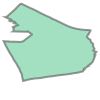

In [35]:
geo = data_bezirke["geometry"][0]
geo

In [145]:
geo2 = data_plz['geometry'][0]
h3.geo_to_cells(geo2, res=9)

['891f1d48d67ffff',
 '891f1d48d4fffff',
 '891f1d488a7ffff',
 '891f1d48d6bffff',
 '891f1d4888fffff',
 '891f1d48c2fffff',
 '891f1d48d53ffff',
 '891f1d488abffff',
 '891f1d489cfffff',
 '891f1d48d6fffff',
 '891f1d488afffff',
 '891f1d489d3ffff',
 '891f1d48897ffff',
 '891f1d48d5bffff',
 '891f1d488b3ffff',
 '891f1d489d7ffff',
 '891f1d48d77ffff',
 '891f1d488a3ffff',
 '891f1d48d4bffff',
 '891f1d48d43ffff',
 '891f1d488b7ffff',
 '891f1d489dbffff',
 '891f1d48d2bffff',
 '891f1d489c3ffff',
 '891f1d48d63ffff',
 '891f1d488bbffff',
 '891f1d48887ffff']

In [178]:
geo_ref = data_plz['geometry'][0]
type(geo_ref)

shapely.geometry.polygon.Polygon

In [183]:
geo_test = data_plz.query('plz == "13599"')['geometry'].iloc[0]
type(geo_test)

shapely.geometry.polygon.Polygon

In [198]:
hexes = [h3.cells_to_geo([cell]) for cell in h3.geo_to_cells(geo_test, res=9)]

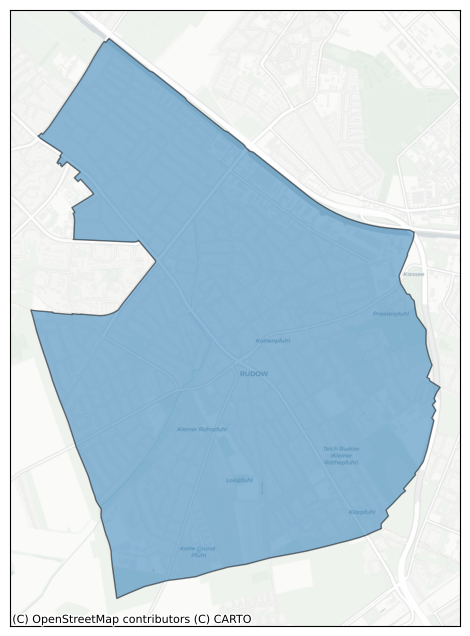

In [38]:
plot_shape(geo)

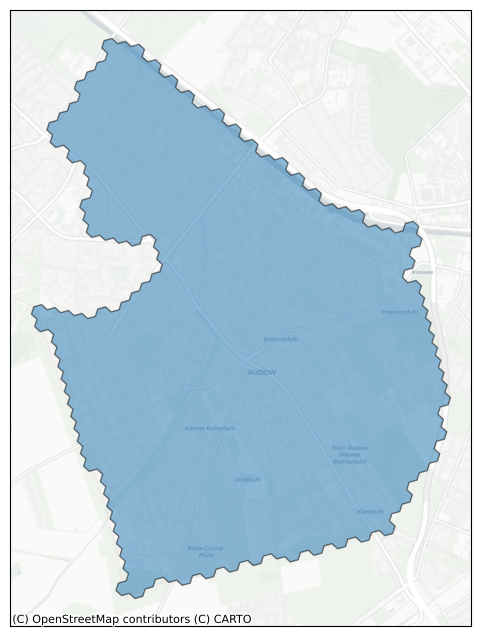

In [102]:
plot_cells(h3.geo_to_cells(geo, res=10))

In [133]:
h3.geo_to_cells(geo, res=9)[0]

'891f18b0ea3ffff'

In [139]:
h3.cells_to_geo(h3.geo_to_cells(geo, res=9)[0:1])

{'type': 'Polygon',
 'coordinates': (((13.478468524176765, 52.413193607584304),
   (13.481054170897703, 52.41252648483747),
   (13.48351716161163, 52.41349791492623),
   (13.483394528166281, 52.41513649462471),
   (13.480808783114892, 52.415803632546286),
   (13.478345769841493, 52.41483217559315),
   (13.478468524176765, 52.413193607584304)),)}

In [99]:
print(h3.cell_to_latlng(h3.geo_to_cells(geo, res=9)[0]))
print(h3.cell_to_latlng(h3.geo_to_cells(geo, res=9)[18]))

(52.41416507987398, 13.48093147998364)
(52.414469287473416, 13.485980244692534)


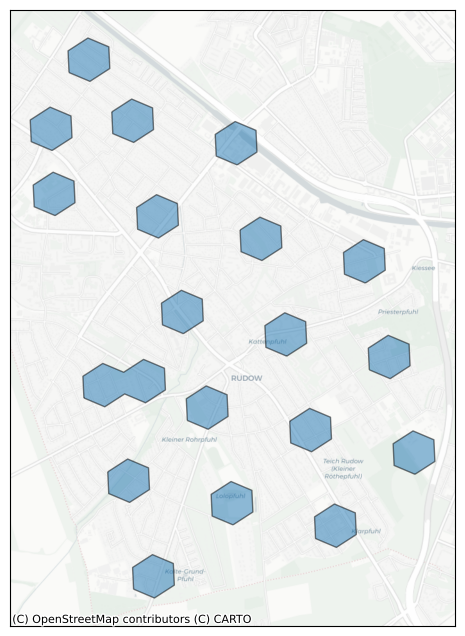

In [59]:
plot_cells(h3.geo_to_cells(geo, res=9)[0:20])

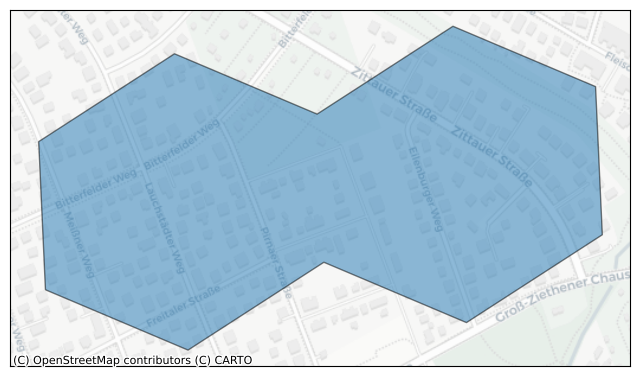

In [98]:
plot_cells([h3.geo_to_cells(geo, res=9)[0], h3.geo_to_cells(geo, res=9)[18]])

In [103]:
fp = "flask-react-app/backend/data/streets/strassenflaechen.shp"
data_streets = gpd.read_file(fp).to_crs(epsg=4326)

data_streets

,gml_id,NAM,FLAECHE,geometry
0,s_ISU5_2015_UA_str.0000000010006599,Nebenstraße,9644.72,"POLYGON ((13.64159 52.52006, 13.64364 52.52147..."
1,s_ISU5_2015_UA_str.0000000010006600,Nebenstraße,16692.27,"POLYGON ((13.64159 52.52006, 13.6418 52.52, 13..."
2,s_ISU5_2015_UA_str.0000000010006604,Nebenstraße,20664.13,"POLYGON ((13.62361 52.5218, 13.62325 52.52185,..."
3,s_ISU5_2015_UA_str.0000000010006605,Nebenstraße,2099.55,"POLYGON ((13.62361 52.5218, 13.62374 52.52178,..."
4,s_ISU5_2015_UA_str.0000000010006606,Nebenstraße,11470.12,"POLYGON ((13.62147 52.52244, 13.62331 52.52439..."
...,...,...,...,...
8025,s_ISU5_2015_UA_str.0000000006001758,Nebenstraße,257.30,"POLYGON ((13.13836 52.39772, 13.13808 52.3978,..."
8026,s_ISU5_2015_UA_str.0000000006003616,Nebenstraße,2071.61,"POLYGON ((13.13957 52.39849, 13.13929 52.39865..."
8027,s_ISU5_2015_UA_str.0000000006005278,Nebenstraße,753.84,"POLYGON ((13.1394 52.39618, 13.13882 52.39624,..."
8028,s_ISU5_2015_UA_str.0000000006007916,Nebenstraße,30029.98,"POLYGON ((13.13031 52.38944, 13.12928 52.38819..."


In [125]:
len(h3.geo_to_cells(geo, res=9))

129

In [119]:
import time

start = time.time()
travel_times = []

idx = 0
for center in [h3.cell_to_latlng(cell) for cell in h3.geo_to_cells(geo, res=9)]:
    location = {'latitude': center[0], 'longitude': center[1]}
    travel_times.append(travel_time(location, flat_locations['Berliner Rechnungshof']))
    idx += 1
    print(idx, end="\r")

end = time.time()
print(end - start)

14.777592897415161


<Axes: ylabel='Count'>

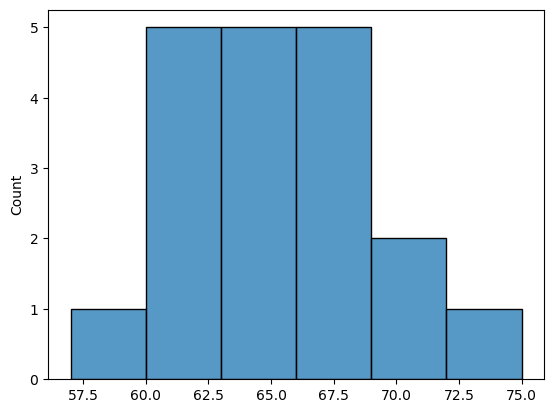

In [120]:
import seaborn

seaborn.histplot([t.seconds//60 for t in travel_times])

In [ ]:
import asyncio
from aiohttp import ClientSession

async def hello(url: str):
    async with ClientSession() as session:
        async with session.get(url) as response:
            response = await response.read()
            print(response)

asyncio.run(hello("http://httpbin.org/headers"))